# Analisis & Klasifikasi Penyakit Jantung (Cleveland Dataset)
Notebook ini berisi: EDA → Preprocessing → Training RandomForest → Evaluasi → Simpan model.
Bahasa: Indonesia
Model utama: RandomForestClassifier


In [10]:
#Import dan load data
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ROOT = Path('.')  # sesuaikan: folder project
DATA_PATH = ROOT / 'data' / 'heart.csv'

df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [11]:
#Ringkasan dataset
print("Shape:", df.shape)
print(df.info())
print("\nDistribusi target (condition):")
print(df['condition'].value_counts())

Shape: (297, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None

Distribusi target (condition):
condition
0    160
1    137
Name: count, dtype: int64


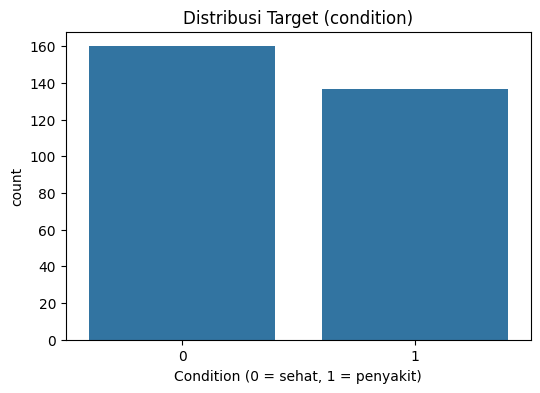

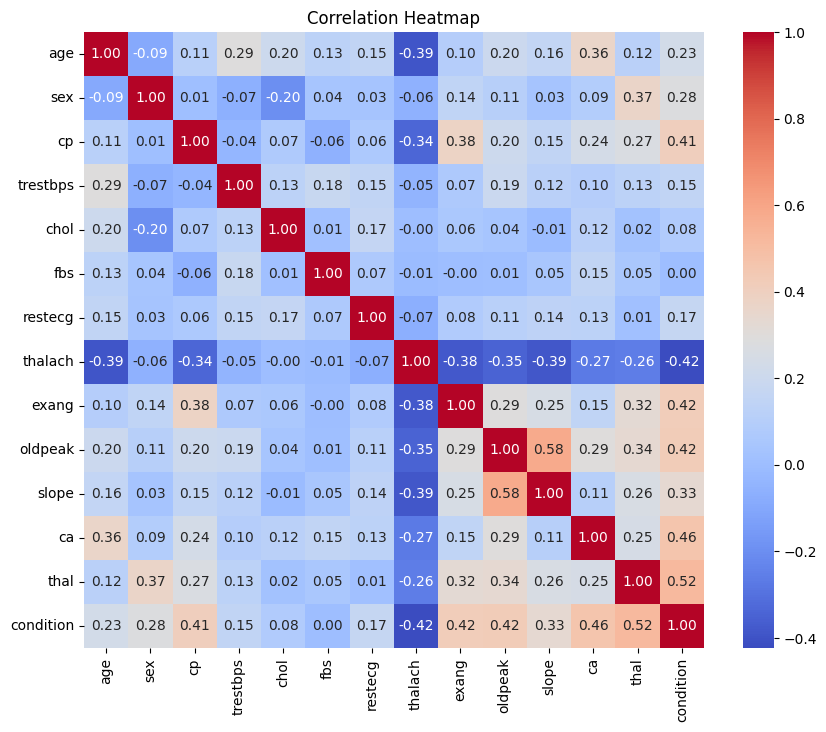

In [12]:
#EDA cepat: distribusi target + korelasi
# Distribusi target
plt.figure(figsize=(6,4))
sns.countplot(x='condition', data=df)
plt.title('Distribusi Target (condition)')
plt.xlabel('Condition (0 = sehat, 1 = penyakit)')
plt.show()

# Korelasi heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [13]:
#Preprocessing: cleaning, split, scaling
from sklearn.model_selection import train_test_split
from utils.preprocessing import basic_cleaning, split_features_target, scale_numeric

# Cleaning
df_clean = basic_cleaning(df)

# Pisah X dan y
X, y = split_features_target(df_clean, target='condition')

# Split stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tentukan kolom numerik untuk scaling
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Scale numeric
X_train_scaled, X_test_scaled, scaler = scale_numeric(X_train, X_test, numeric_cols)

print("X_train:", X_train_scaled.shape, "X_test:", X_test_scaled.shape)

X_train: (237, 13) X_test: (60, 13)


In [14]:
#Training RandomForest
from sklearn.ensemble import RandomForestClassifier
import joblib
from pathlib import Path

models_dir = Path('models')
models_dir.mkdir(parents=True, exist_ok=True)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Simpan model
model_path = models_dir / 'random_forest_model.pkl'
joblib.dump(rf, model_path)
print("Model tersimpan di:", model_path)

Model tersimpan di: models\random_forest_model.pkl


Accuracy: 0.8667

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.95      0.75      0.84        28

    accuracy                           0.87        60
   macro avg       0.89      0.86      0.86        60
weighted avg       0.88      0.87      0.86        60



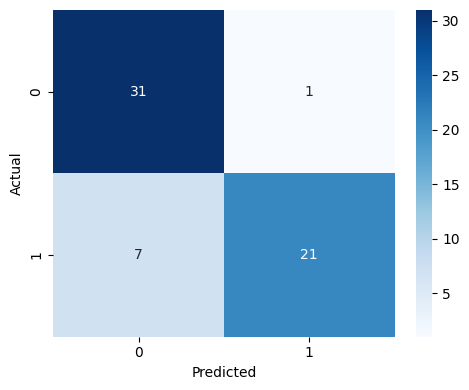

Laporan performa disimpan di reports/model_performance.txt


In [15]:
#Evaluasi model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from utils.evaluation import print_metrics, plot_confusion
import numpy as np
from pathlib import Path

# Prediksi
y_pred = rf.predict(X_test_scaled)

# Metrics
print_metrics(y_test, y_pred)

# Plot confusion (dan simpan)
visuals_dir = Path('visuals')
visuals_dir.mkdir(parents=True, exist_ok=True)
plot_confusion(y_test, y_pred, save_path=visuals_dir/'confusion_matrix.png')

# Simpan classification report & accuracy ke file
reports_dir = Path('reports')
reports_dir.mkdir(parents=True, exist_ok=True)
acc = accuracy_score(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)
with open(reports_dir/'model_performance.txt', 'w') as f:
    f.write(f"Accuracy: {acc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(clf_report)
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(confusion_matrix(y_test, y_pred)))
print("Laporan performa disimpan di reports/model_performance.txt")

Feature importances:
 thalach     0.148993
cp          0.119630
oldpeak     0.117138
ca          0.111327
thal        0.101937
age         0.095834
chol        0.084904
trestbps    0.074466
exang       0.051387
slope       0.040518
sex         0.025716
restecg     0.019492
fbs         0.008658
dtype: float64


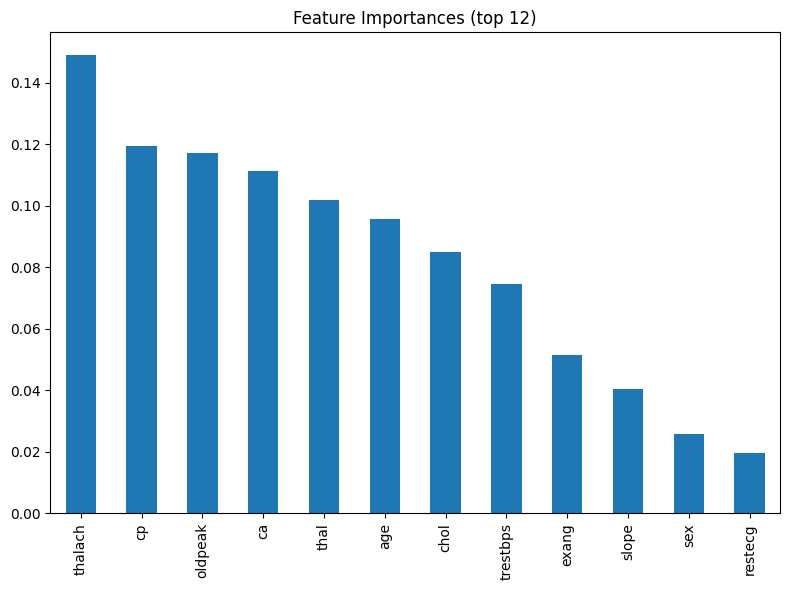

In [16]:
#Feature importance & visualisasi tambahan
import pandas as pd
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature importances:\n", feat_imp)

# Simpan plot importances
plt.figure(figsize=(8,6))
feat_imp.head(12).plot(kind='bar')
plt.title("Feature Importances (top 12)")
plt.tight_layout()
plt.savefig(visuals_dir/'feature_importances.png')
plt.show()

In [17]:
# Membuat ringkasan sederhana dan menyimpan sebagai PDF (menggunakan matplotlib)
import matplotlib.backends.backend_pdf as mppd
fig = plt.figure(figsize=(8.27, 11.69))
plt.axis('off')
text = f"""
EDA Summary - Heart Disease (Cleveland)

Rows: {df_clean.shape[0]}
Columns: {df_clean.shape[1]}

Target distribution:
{df_clean['condition'].value_counts().to_string()}

Top feature importances:
{feat_imp.head(10).to_string()}

Notes:
- Tidak ditemukan missing values (per dataset ini).
- Semua fitur numerik siap untuk scaling.
"""
plt.text(0.01, 0.99, text, va='top', wrap=True, fontsize=10)
pdf = mppd.PdfPages('reports/eda_summary.pdf')
pdf.savefig(fig, bbox_inches='tight')
pdf.close()
plt.close(fig)
print("EDA summary disimpan di reports/eda_summary.pdf")

EDA summary disimpan di reports/eda_summary.pdf


In [2]:
# =============================================================
# Exploratory Data Analysis (EDA) - Heart Disease Classification
# Visualisasi: distribusi usia/gender, korelasi, dan scatter age-bp
# =============================================================

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan folder visuals ada
os.makedirs("visuals", exist_ok=True)
# Load dataset
df = pd.read_csv("data/heart.csv")

# Jika kolom target belum dinamai 'condition', ubah dari 'target'
if 'condition' not in df.columns and 'target' in df.columns:
    df = df.rename(columns={'target': 'condition'})

# -------------------------------------------------------------
# 1️⃣ Distribusi pasien berdasarkan usia dan jenis kelamin
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='sex', multiple='stack', bins=20)
plt.title("Distribusi Pasien Berdasarkan Usia dan Jenis Kelamin")
plt.xlabel("Usia (tahun)")
plt.ylabel("Jumlah Pasien")
plt.legend(title="Jenis Kelamin", labels=["Perempuan (0)", "Laki-laki (1)"])
plt.tight_layout()
plt.savefig("visuals/distribusi_usia_gender.png", dpi=300)
plt.close()
print("✅ Saved: visuals/distribusi_usia_gender.png")

# -------------------------------------------------------------
# 2️⃣ Analisis korelasi antar fitur terhadap variabel target
# -------------------------------------------------------------
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", square=True, linewidths=0.5)
plt.title("Heatmap Korelasi Antar Fitur dan Target")
plt.tight_layout()
plt.savefig("visuals/heatmap_korelasi.png", dpi=300)
plt.close()
print("✅ Saved: visuals/heatmap_korelasi.png")

# -------------------------------------------------------------
# 3️⃣ Distribusi kondisi pasien berdasarkan usia dan tekanan darah
# -------------------------------------------------------------
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df,
    x='age',
    y='trestbps',   # trestbps = resting blood pressure
    hue='condition',
    palette='coolwarm',
    alpha=0.7
)
plt.title("Distribusi Kondisi Pasien Berdasarkan Usia dan Tekanan Darah")
plt.xlabel("Usia (tahun)")
plt.ylabel("Tekanan Darah Istirahat (mm Hg)")
plt.legend(title="Condition", labels=["Sehat (0)", "Penyakit (1)"])
plt.tight_layout()
plt.savefig("visuals/distribusi_usia_tekanandarah.png", dpi=300)
plt.close()
print("✅ Saved: visuals/distribusi_usia_tekanandarah.png")

print("\n📊 Semua visualisasi EDA berhasil dibuat dan disimpan di folder 'visuals/'.")

✅ Saved: visuals/distribusi_usia_gender.png
✅ Saved: visuals/heatmap_korelasi.png
✅ Saved: visuals/distribusi_usia_tekanandarah.png

📊 Semua visualisasi EDA berhasil dibuat dan disimpan di folder 'visuals/'.
